# Temperature calculated by DTS interrogator

In [1]:
import os
import glob
import h5py
import numpy as np
import pandas as pd
import matplotlib
from obspy import UTCDateTime
from das_util import get_tstamp_dts, calc_NFFT
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})

## Step 1- Merge segemented files and Quality control

In [21]:
# %% sort and merge files
data_dir = '/fd1/QibinShi_data/England_farm/England_DTS/DTS_England_channel1'
file_list = np.array(sorted(glob.glob(data_dir+'/England_Bugs_distributed_data*.csv')))
df_list = []

# %% continuous time after 10th file based on manual check 
for fname in file_list[10:]:
    df = pd.read_csv(fname, low_memory=False)
    ds = pd.to_numeric(df['Unnamed: 0'], errors='coerce')
    df = df.loc[(ds > 0) & (ds < 600)]
    df.drop(df.columns[df.columns.str.contains('unnamed',case=False)], axis=1, inplace=True)
    df_list.append(df)
df = pd.concat(df_list, axis=1)

df.to_csv(data_dir + '/merged_temperature_4seg.csv', sep=',', index=False)

In [3]:
# # %% only run this cell after the previous one has been executed
# df = pd.read_csv(data_dir + '/merged_temperature.csv', low_memory=False)

[UTCDateTime(2023, 3, 17, 18, 25, 47) UTCDateTime(2023, 3, 17, 18, 26, 9)
 UTCDateTime(2023, 3, 17, 18, 26, 31) ...
 UTCDateTime(2023, 3, 19, 10, 16, 15) UTCDateTime(2023, 3, 19, 10, 16, 37)
 UTCDateTime(2023, 3, 19, 10, 16, 59)]


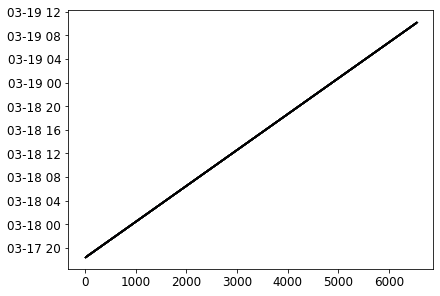

In [24]:
# check if the time of measurements is continous (linear)
time_labels = df.keys().to_numpy()
start_time = np.array([get_tstamp_dts(i) for i in time_labels])
print(start_time)
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(6,4), constrained_layout=True)
ax.scatter(np.arange(len(start_time)), start_time.astype('datetime64[s]'), marker='o', s=0.1, edgecolors='k')

In [25]:
ds[(ds > 0) & (ds < 600)].values.shape

(2360,)

In [39]:
df.values.astype(float)

array([[22.271, 22.295, 22.353, ..., 19.506, 19.696, 19.608],
       [20.267, 20.39 , 20.406, ..., 15.947, 16.168, 16.176],
       [16.935, 17.154, 17.177, ..., 11.759, 11.997, 12.003],
       ...,
       [11.573, 11.335, 11.511, ...,  8.306,  8.429,  8.381],
       [11.49 , 11.274, 11.501, ...,  8.313,  8.388,  8.282],
       [11.515, 11.417, 11.64 , ...,  8.34 ,  8.363,  8.275]])

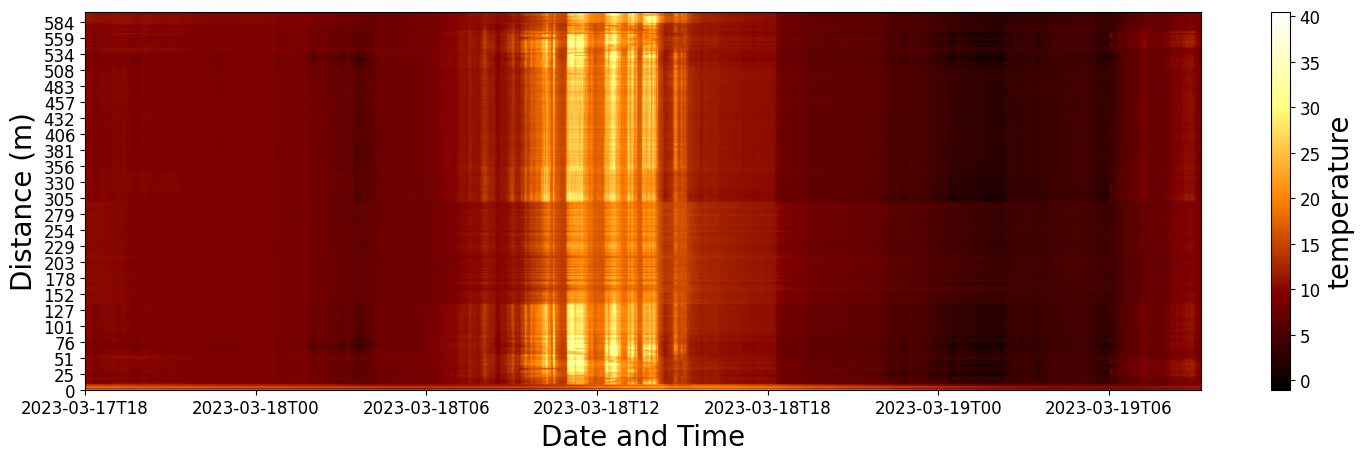

In [40]:
# %% visualize the temperature in time-space
channel_space = 0.254

plt.close('all')
plt.figure(figsize = (18, 5), dpi = 100)
plt.imshow(df.values.astype(float), cmap='afmhot', aspect='auto', origin='lower')

plt.ylabel("Distance (m)", fontsize = 20)
plt.xlabel("Date and Time", fontsize = 20)
plt.xticks(np.arange(0, df.shape[1], 1000), 
           start_time[0: df.shape[1]: 1000].astype('datetime64[h]'))
plt.yticks(np.arange(0, df.shape[0], 100), 
           ds[(ds > 0) & (ds < 600)].values[::100].astype(int))
cbr = plt.colorbar()
cbr.set_label('temperature', fontsize = 20)

In [7]:
df.values.shape

(590, 6541)

## Step 2- Get the data for a time window

In [55]:
def get_dts(starttime, endtime):
    df = pd.read_csv(data_dir + '/merged_temperature_4seg.csv', low_memory=False)
    time_labels = df.keys().to_numpy()
    start_time = np.array([get_tstamp_dts(i) for i in time_labels])
    
    time_idx = np.where(np.logical_and(start_time<endtime, start_time>starttime))[0]

    return df.iloc[:, time_idx].values.astype(float), start_time[time_idx]

Text(0.5, 0, 'Date and Time')

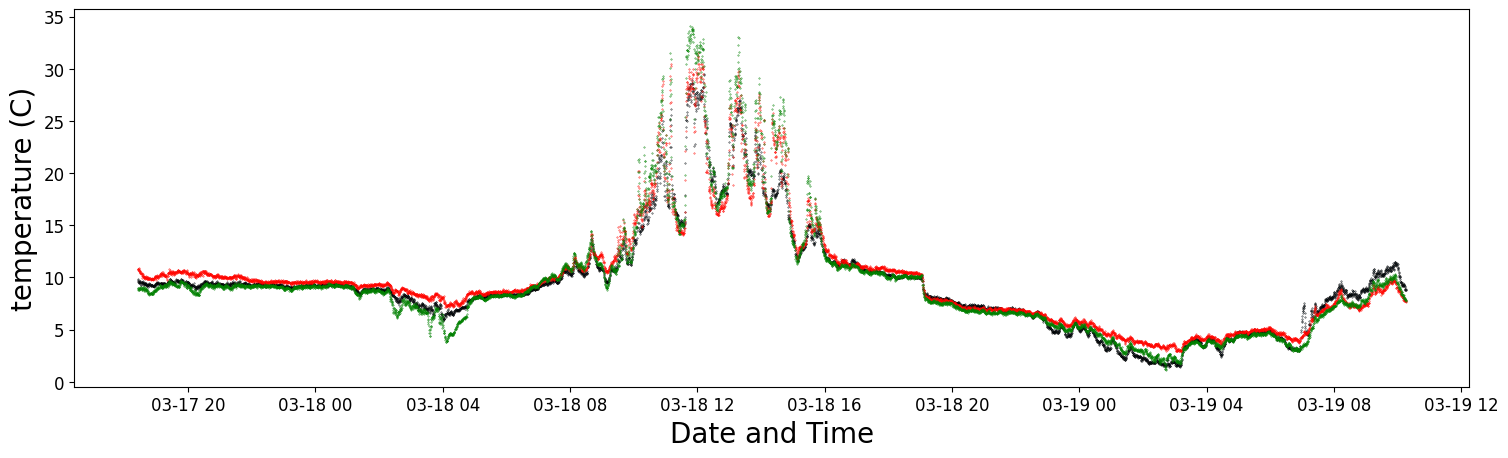

In [64]:
temp_window, time_window = get_dts(starttime=UTCDateTime(2023, 3, 17, 17, 53), 
                                   endtime=UTCDateTime(2023, 3, 19, 10, 31))

plt.close('all')
plt.figure(figsize = (18, 5), dpi = 100)
plt.scatter(time_window.astype('datetime64[m]'), temp_window[100], marker='o', s=0.1, edgecolors='k')
plt.scatter(time_window.astype('datetime64[m]'), temp_window[200], marker='o', s=0.1, edgecolors='r')
plt.scatter(time_window.astype('datetime64[m]'), temp_window[300], marker='o', s=0.1, edgecolors='g')
plt.ylabel("temperature (C)", fontsize = 20)
plt.xlabel("Date and Time", fontsize = 20)

In [72]:
from das_util import read_decimate, get_tstamp

with h5py.File('/fd1/QibinShi_data/England_farm/interp_dvv_temp_moisture.hdf5', 'r') as f:
    interp_dvv = f['dvv'][:]
    interp_cc = f['cc'][:]
    interp_temp10 = f['temperature'][:]
    interp_humidity = f['moisture'][:]
    ave_psd = f['psd_rain'][:]
with h5py.File('/fd1/QibinShi_data/England_farm/psd_all.hdf5', 'r') as f:
    file_list = f['daslist'][:].astype('U')
#     PSD_all_time = f['psd_all_time'][:]
#     freq = f['frequency'][:]

acqu_time = np.array([get_tstamp(i) for i in file_list])
unix_tvec = np.array([x.timestamp for x in acqu_time])
unix_tvec_fine = np.array([x.timestamp for x in time_window])

In [75]:
# interpolate 
from scipy.interpolate import interp1d

interp_f = interp1d(unix_tvec_fine, temp_window, axis=-1, bounds_error=False, fill_value="extrapolate")
interp_time = interp_f(unix_tvec)

In [76]:
dist_das = np.arange(44, 95)*3.19047627
dist_dts = ds[(ds > 0) & (ds < 600)].values
interp_f = interp1d(dist_dts, interp_time, axis=0, bounds_error=False, fill_value="extrapolate")
interp_temp0 = interp_f(dist_das)

In [82]:
ds[(ds > 0) & (ds < 600)].values[300]

76.485

In [78]:
with h5py.File('/fd1/QibinShi_data/England_farm/interp_dvv_temp_moisture_dts.hdf5', 'w') as f:
    f.create_dataset("dvv", data=interp_dvv)
    f.create_dataset("cc", data=interp_cc)
    f.create_dataset("temperature10", data=interp_temp10)
    f.create_dataset("temperature0", data=interp_temp0)
    f.create_dataset("moisture", data=interp_humidity)
    f.create_dataset("psd_rain", data=ave_psd)

## Step 3- Compare with the DAS data

In [12]:
# %% read DAS
datah5 = data_dir + '/farmDAS_harper_0_24hr.hdf5'
with h5py.File(datah5, 'r') as f:
    full_time_data_h5 = f["data"][:]
    sample_rate_h5 = f["dt"][()]
    time_stamp_h5 = f["timestamp"][:]

sample_rate = sample_rate_h5
acqu_time = np.array([UTCDateTime(i) for i in time_stamp_h5])


In [13]:
# %% read DTS
df = pd.read_csv(data_dir + '/merged_temperature.csv', low_memory=False)
start_time = np.array([get_tstamp_dts(i) for i in df.keys().to_numpy()])
time_idx = np.where(start_time<acqu_time[0]+36*3600)[0]

df = df.iloc[:, time_idx]

temp_window, time_window = get_dts(channel=416, 
                                   starttime=start_time[0], 
                                   endtime=acqu_time[0]+36*3600)


In [14]:
start_ch, end_ch = 44, 94            # channel range
ch_id = 33                           # choose a channel to visualize
start_minutes = 0                    # starting file indice for reading
num_minutes = 2160                    # number of semi-continuous 1-min files to merge
num_seconds = int(num_minutes * 60)  # total duration (s) of merged time series
dsamp_factor = 20                    # downsample rate when reading raw time series
sample_rate = int(2000 / dsamp_factor)    # final sample rate after downsampling
shift_min = 7                        # shift in minutes of the first tick when ploting
shift_sec = int(shift_min * 60)      # shift in seconds
file_inc = 360                       # plot ticks for every {file_inc} 1-min files 
time_inc = int(file_inc * 60)        # tick interval in seconds

In [15]:
time_diff = int((start_time[0]-acqu_time[0])/60)
full_time_data = full_time_data_h5[:, time_diff:]

NFFT=8192 samples, equivalent to 81.92 seconds
saturated for period > 40.96 seconds
(819, 1807) (819,) (1807,)
(2047, 1807) (2047,) (1807,)


Text(0.5, 0, 'time ')

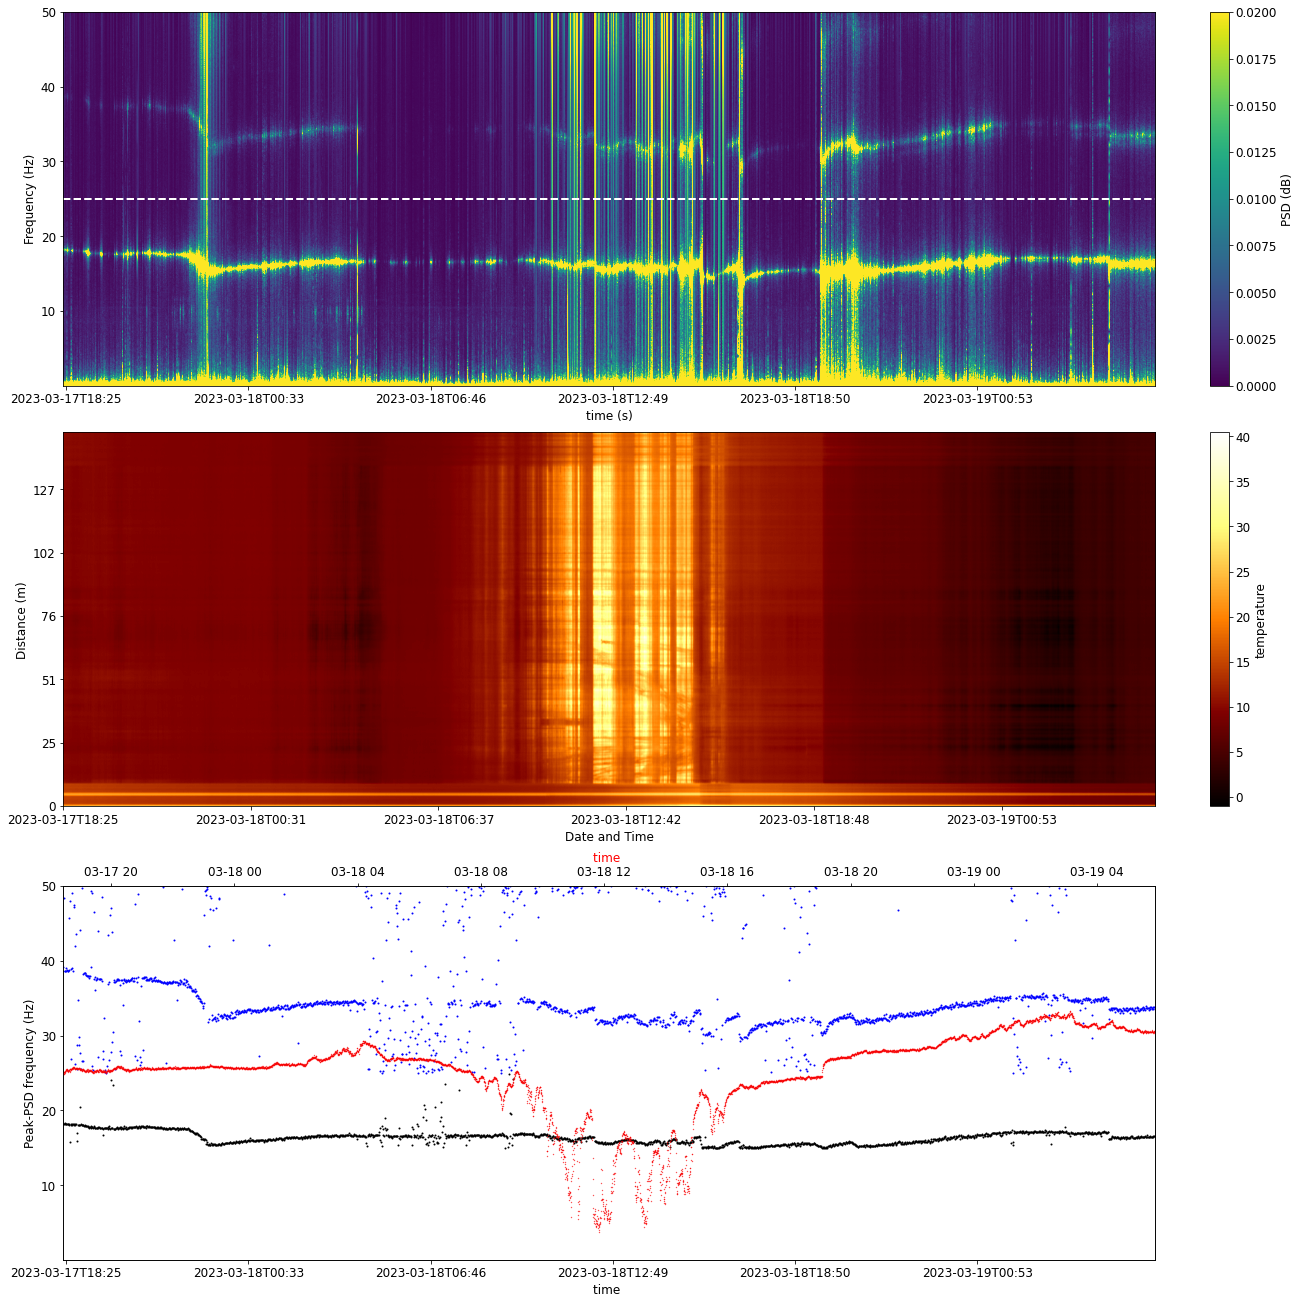

In [16]:
# %% calculate the best NFFT for plotting
nfft, time_width = calc_NFFT(full_time_data[33], sample_rate, power_of_2=True)
print(f'saturated for period > {time_width/2} seconds')
# %% plot data in time-frequency
plt.close('all')
fig, ax = plt.subplots(3, 1, figsize=(18, 18), constrained_layout=True)
Pxx,freqs,bins,image=ax[0].specgram(full_time_data[ch_id],Fs=sample_rate,
                                    mode='magnitude',NFFT=nfft,noverlap=int(nfft/8), 
                                    scale='linear', vmin=0, vmax=0.02)
hline = ax[0].axhline(25, linestyle='--', linewidth=2, color='w') 
cbr = fig.colorbar(image, ax=ax[0])
cbr.set_label('PSD (dB)', fontsize = 12)

# ax[0].set_yscale("log")
ax[0].set_ylim(2/time_width, sample_rate/2)
ax[0].set_xlabel("time (s)", fontsize = 12)
ax[0].set_ylabel("Frequency (Hz)", fontsize = 12)

# %% set up time ticks for every 20 minutes (20 1-min files)
ax[0].set_xticks(np.arange(0+shift_sec, num_seconds, time_inc))
ax[0].set_xticklabels(time_diff+acqu_time[start_minutes:start_minutes+num_minutes:file_inc].astype('datetime64[m]'))


# %% 1st mode resonance of every time bin
ind = np.where(np.logical_and(freqs > 15, freqs < 25))[0]
Pxx1 = Pxx[ind, :]
freqs1 = freqs[ind]
# %% 2nd mode resonance of every time bin
ind = np.where(np.logical_and(freqs > 25, freqs < 50))[0]
Pxx2 = Pxx[ind, :]
freqs2 = freqs[ind]

freq_ind1 = np.argmax(Pxx1, axis=0)
freq_ind2 = np.argmax(Pxx2, axis=0)
print(Pxx1.shape, freqs1.shape, freq_ind1.shape)
print(Pxx2.shape, freqs2.shape, freq_ind2.shape)

ax[2].scatter(bins, freqs1[freq_ind1], marker='o', s=1, edgecolors='k')
ax[2].scatter(bins, freqs2[freq_ind2], marker='o', s=1, edgecolors='b')
ax[2].set_ylim(2/time_width, sample_rate/2)
ax[2].set_xlim(bins[0], bins[-1])
ax[2].set_xlabel("time ", fontsize = 12)
ax[2].set_ylabel("Peak-PSD frequency (Hz)", fontsize = 12)
ax[2].set_xticks(np.arange(0+shift_sec, num_seconds, time_inc))
ax[2].set_xticklabels(time_diff+acqu_time[start_minutes:start_minutes+num_minutes:file_inc].astype('datetime64[m]'))

# %% visualize the temperature in time-space
channel_space = 0.254

image = ax[1].imshow(df.values, cmap='afmhot', aspect='auto', origin='lower')

ax[1].set_ylabel("Distance (m)", fontsize = 12)
ax[1].set_xlabel("Date and Time", fontsize = 12)
ax[1].set_xticks(np.arange(0, df.shape[1], 1000))
ax[1].set_xticklabels(start_time[0: df.shape[1]: 1000].astype('datetime64[m]'))
ax[1].set_yticks(np.arange(0, df.shape[0], 100)) 
ax[1].set_yticklabels(np.rint(np.arange(0, df.shape[0], 100) * channel_space).astype(int))
cbr = fig.colorbar(image, ax=ax[1])
cbr.set_label('temperature', fontsize = 12)

axcopy = ax[2].twiny()
axcopy.scatter(time_window.astype('datetime64[s]'), 35-temp_window, marker='o', s=0.1, edgecolors='r')
axcopy.set_xlim(start_time[0], acqu_time[0]+36*3600)
axcopy.set_xlabel("time ", fontsize = 12, color='r')